This notebook is an adaptation from Lisa Alazraki's notebook used for training the previous version of the chatbot (https://www.doc.ic.ac.uk/~ae/papers/Lisa_Alazraki_report.pdf).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install transformers tokenizers
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
!pip install "ray[tune]"

In [ ]:
#package imports 

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pytorch_lightning as pl

from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, BertTokenizer, RobertaTokenizer
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
from ray import tune
from ray.tune.integration.pytorch_lightning import TuneReportCallback

from typing import List
import logging
import copy
import os
import sys
import gc
import random
from functools import lru_cache
from argparse import Namespace
from packaging import version
from tqdm.autonotebook import tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(21)

In [ ]:
train_path = "/content/drive/MyDrive/Individual Project/Data/Emotion/bt_train.txt"
test_path = "/content/drive/MyDrive/Individual Project/Data/Emotion/bt_test.txt"
val_path = "/content/drive/MyDrive/Individual Project/Data/Emotion/bt_val.txt"

In [ ]:
#create a dictionary which associates each string label to an integer value
labels = [ "sadness", "joy", "anger", "fear", "love", "instability", "disgust", "disappointment", "shame", "guilt", "envy", "jealous"]
label2int = dict(zip(labels, list(range(len(labels)))))

In [ ]:
#load tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-large')

!mkdir -p tokenizer

tokenizer.save_pretrained("tokenizer")

!ls tokenizer

merges.txt		 tokenizer_config.json	vocab.json
special_tokens_map.json  tokenizer.json


In [ ]:

class EmotionClassificationModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=1024, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            nn.Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        
        return self.classifier(hidden_states[0][:, 0, :])

In [ ]:
class TokenizersCollateFn:
    def __init__(self, max_tokens=128): 

        t = ByteLevelBPETokenizer(
            "/content/tokenizer/vocab.json",
            "/content/tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels

In [ ]:

class EmotionDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "class"
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                               engine="python")

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

    def __len__(self):
        return self.data.shape[0]

In [ ]:
class TrainingModule(pl.LightningModule):
    def __init__(self, params):
        super().__init__()
        self.model = EmotionClassificationModel(AutoModelWithLMHead.from_pretrained("roberta-large").base_model, len(labels))
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters(params)
        self.train_path = params['train_path']
        self.test_path = params['test_path']
        self.val_path = params['val_path']
        self.lr = params['lr']
        self.epochs = params['epochs']
        self.batch_size = params['batch_size']
        self.accumulate_grad_batches = params['accumulate_grad_batches']
        self.warmup_steps = params['warmup_steps']


    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}
        self.log(f"ptl/{loss_key}", loss)

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmotionDataset(ds_path),
                    batch_size=self.batch_size,
                    num_workers=4,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.accumulate_grad_batches * self.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.lr) #we use AdamW as this usually performs well
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

    def save_model(self):
        torch.save(self.model.state_dict(), '/content/RoBERTa_large_finetuned_bt.pt')

In [ ]:
#chosen hyperparams:
train_config = dict(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=10,
    lr=5E-05,
    accumulate_grad_batches=2
)

In [ ]:
model = TrainingModule(train_config)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=train_config['epochs'],
                     accumulate_grad_batches=train_config['accumulate_grad_batches'])

trainer.fit(model)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:440: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | EmotionClassificationModel | 35

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    model.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(model.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(model(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))


________________________________________________________________________________
                precision    recall  f1-score   support

       sadness     0.8824    0.7895    0.8333        38
           joy     0.9091    0.9375    0.9231        32
         anger     0.9200    0.8519    0.8846        27
          fear     0.8333    0.8929    0.8621        28
          love     0.9355    0.9062    0.9206        32
   instability     0.8571    0.9000    0.8780        20
       disgust     0.8750    0.8400    0.8571        25
disappointment     0.8696    1.0000    0.9302        20
         shame     0.8889    1.0000    0.9412        16
         guilt     0.9000    0.8182    0.8571        22
          envy     0.9286    0.9286    0.9286        28
       jealous     0.8966    0.9286    0.9123        28

      accuracy                         0.8924       316
     macro avg     0.8913    0.8994    0.8940       316
  weighted avg     0.8932    0.8924    0.8916       316



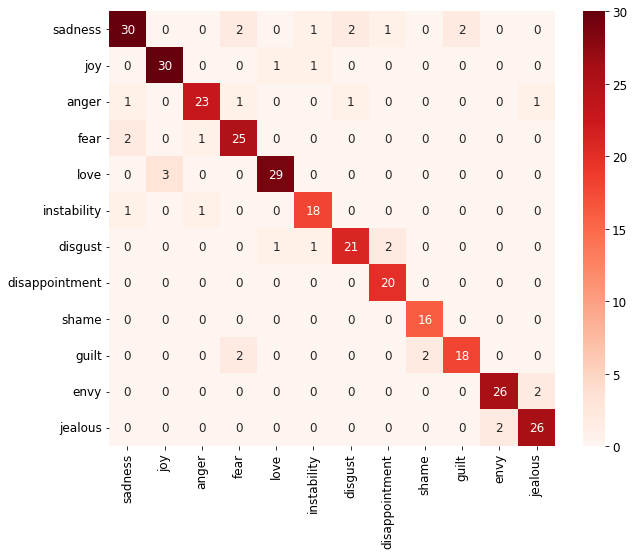

In [ ]:
#plot confusion matrix

cm = confusion_matrix(true_y, pred_y, labels=range(len(labels)))
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.rcParams.update({'font.size': 12}) 
plt.figure(figsize = (10,8));
sn.heatmap(df_cm, annot=True, cmap='Reds', fmt='g');

In [ ]:
model.save_model()

Hyperparameter Tuning

In [ ]:
tune_config = dict(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    warmup_steps=100,
    # parameters to tune
    batch_size=tune.grid_search([4, 8, 16, 32]),
    lr=tune.grid_search([1.35E-4, 5E-4, 1.35E-5, 5E-5, 1.35E-6]),
    epochs=tune.grid_search([6, 10, 16, 20]),
    accumulate_grad_batches=tune.grid_search([1,2,4,8])
)

In [ ]:
def tune_model(config, num_gpus=1):
    model = TrainingModule(config)
    metrics = {"loss": "ptl/val_loss"}
    trainer = pl.Trainer(
        max_epochs=config['epochs'],
        gpus=num_gpus,
        accumulate_grad_batches=config['accumulate_grad_batches'],
        callbacks=[TuneReportCallback(metrics, on="validation_end")])
    trainer.fit(model)

In [ ]:
trainable = tune.with_parameters(
    tune_model,
    num_gpus = 1
)

In [ ]:
analysis = tune.run(
    trainable,
    resources_per_trial = {
        "cpu": 4,
        "gpu": 1
    },
    metric="loss",
    mode="min",
    num_samples=1,
    config=tune_config
)

print(analysis.best_config)